In [15]:
# install packages if necessary
!pip3 install pandas
!pip3 install numpy --upgrade

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/input\test.csv
./data/input\train.csv


# **1. Preprocessing**

## Modify 'Name' column : remove firstName and keep lastName of passengers
#### *Tracking same family members might lead to better prediction*

In [3]:
df = pd.read_csv("./data/input/train.csv")

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:

def remove_first_name(df):
    # remove first names of all passengers but keep last name
    df = df.copy()
    df.Name = df.Name.astype(str)
    mask = lambda x : x if len(x.split()) < 2 else x.split()[1]
    df.Name = df.Name.apply(mask)

    return df

df = remove_first_name(df)
df.Name.head()

0      Ofracculy
1          Vines
2         Susent
3         Susent
4    Santantines
Name: Name, dtype: object

## Impute missing values

In [6]:
def impute_missing_values(df):
    df = df.copy()
    df.fillna({'Name': 'Unknown'}, inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

df = impute_missing_values(df)
missing_val_count_by_column = (df.isnull().sum())
print("Missing values:")
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Missing values:
Series([], dtype: int64)


## Cast non-categorical and non-float values to int64

In [7]:

def preprocess(df, has_target=True):
    df = df.copy()
    df.replace(to_replace=True,value=1,inplace=True)
    df.replace(to_replace=False,value=0,inplace=True)
    df['CryoSleep']= df['CryoSleep'].astype(np.int64)
    df['VIP']= df['VIP'].astype(np.int64)

    if has_target:
        df['Transported'] = df['Transported'].astype(np.int64)
    
    return df

df = preprocess(df)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Ofracculy,0
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Vines,1
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Susent,0
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Susent,0
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Santantines,1


# **2. Building and testing model using sklearn RandomForestClassifier**

### *Importing dependencies*

In [14]:
# install packages if necessary
!pip3 install category_encoders
!pip3 install seaborn

In [10]:
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
import seaborn as sns
from sklearn.metrics import accuracy_score

### *Building the model*

The model has an accuray score of : 0.7740080506037953


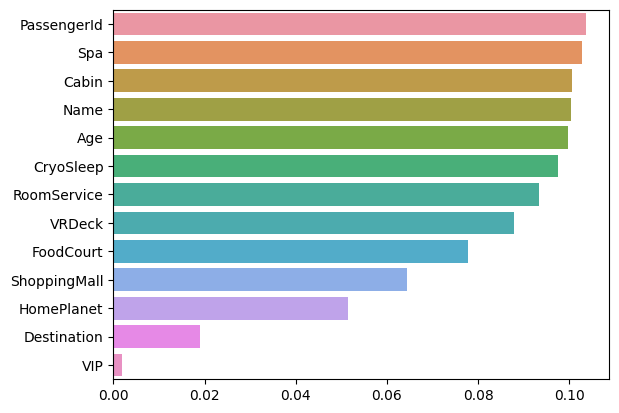

In [12]:
# Split data into training and testing data

features = df.drop("Transported", axis=1)
target = df.get("Transported")
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.2,random_state=1337)
X_train.shape, X_test.shape

# One-hot encode categorical data
categorical_cols = df.select_dtypes(include=object).columns
encoder = ce.OrdinalEncoder(cols=categorical_cols)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# RandomForestClassifier

model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

# Test model

y_pred = model.predict(X_test)
feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Visualize feature scores
sns.barplot(x=feature_scores,y=feature_scores.index)

print(f"The model has an accuray score of : {accuracy_score(y_test, y_pred)}")

### *Making predictions on test.csv*

In [13]:
# Predict on test data
df_test = pd.read_csv("./data/input/test.csv")
df_test = remove_first_name(df_test)
df_test = impute_missing_values(df_test)
df_test = preprocess(df_test, False)
X_test = encoder.fit_transform(df_test)
pred = model.predict(X_test)

df = pd.DataFrame()
df["PassengerId"] = df_test.PassengerId.astype(str)
df["Transported"] = pred
df.replace({0:False, 1:True}, inplace=True)
df.to_csv("./data/output/submission_titanic.csv")
print(df.count())

df.head()

PassengerId    4277
Transported    4277
dtype: int64


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
